In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [5]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

## Collecting Photos

In [6]:
!tar -xf lfw.tgz

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

NotADirectoryError: [Errno 20] Not a directory: 'lfw/.DS_Store'

In [8]:
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/1659c20a-12d4-11ef-b99c-42e2edd4dbe4.jpg'

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()

    frame = frame[:250,:250, :]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

2024-05-15 21:18:29.343 python[99264:36304976] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


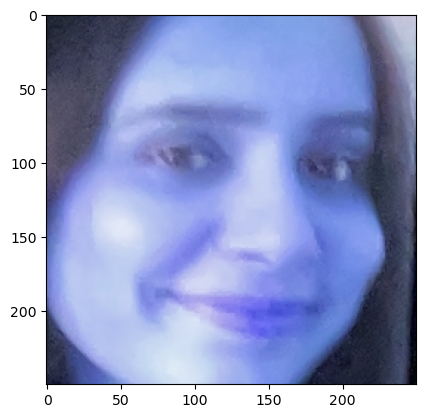

In [11]:
plt.imshow(frame[:250,:250,:])

#### Image Directories

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [11]:
ANC_PATH+'/*.jpg'

'data/anchor/*.jpg'

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
dir_test.next()

b'data/anchor/5907209e-105d-11ef-b2da-42e2edd4dbe4.jpg'

In [14]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [15]:
img = preprocess('data/anchor/7d8896f4-1059-11ef-b2da-42e2edd4dbe4.jpg')

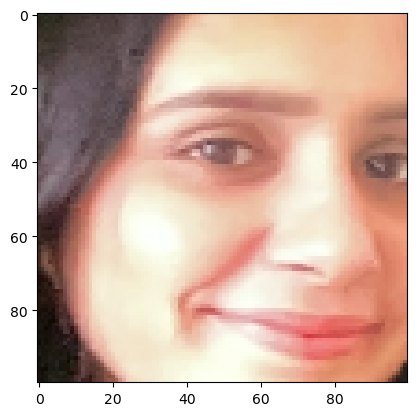

In [16]:
plt.imshow(img)

In [17]:
img.numpy().max() 

1.0

In [18]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [25]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [26]:
samples = data.as_numpy_iterator()

In [27]:
exampple = samples.next()
exampple 

(b'data/anchor/a6450ff6-1058-11ef-b2da-42e2edd4dbe4.jpg',
 b'data/positive/5907209e-105d-11ef-b2da-42e2edd4dbe4.jpg',
 1.0)

In [28]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

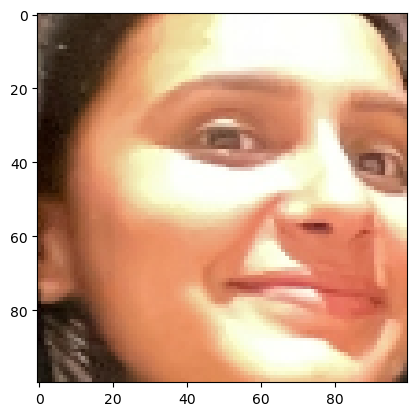

In [29]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])

In [30]:
res[2]

1.0

In [31]:
#dataloader
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [32]:
#training
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [33]:
#testing
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [34]:
inp = Input(shape=(100,100,3), name='input_image')

In [35]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [36]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [37]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [38]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [39]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [40]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [41]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [43]:
embedding = make_embedding()

In [44]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

#### Embedding

In [45]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [46]:
l1 = L1Dist()

In [47]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [48]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [49]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [50]:
inp_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_18>

In [51]:
val_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_19>

In [52]:
siamese_layer = L1Dist()

In [53]:
def make_siamese_model(): 
    
    input_image = Input(name='input_img', shape=(100,100,3))
    
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [54]:
siamese_model = make_siamese_model()

In [55]:
make_siamese_model().summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[4][0],  │
│                     │                   │            │ embedding[5][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training The Model

In [56]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [57]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [58]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [59]:
test_batch = train_data.as_numpy_iterator()

In [60]:
batch_1 = test_batch.next()

In [61]:
X = batch_1[:2]

In [62]:
y = batch_1[2]
y

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [63]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedi

In [64]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [65]:
from tensorflow.keras.metrics import Precision, Recall

In [66]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [67]:
EPOCHS = 50

In [68]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.69026226 0.5 1.0

 Epoch 2/50


2024-05-15 21:30:19.921507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
0.6545329 0.54545456 0.75

 Epoch 3/50


2024-05-15 21:30:25.522803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
0.59555453 0.5555556 1.0

 Epoch 4/50


2024-05-15 21:30:31.305278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
0.5237516 0.6363636 1.0

 Epoch 5/50


2024-05-15 21:30:37.322753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
0.32128868 0.5 1.0

 Epoch 6/50


2024-05-15 21:30:43.505201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
0.28607744 0.6363636 1.0

 Epoch 7/50


2024-05-15 21:30:49.877827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
0.13653156 0.8888889 1.0

 Epoch 8/50


2024-05-15 21:30:56.312282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.07582071 0.90909094 1.0

 Epoch 9/50


2024-05-15 21:31:02.897065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.28354365 0.875 1.0

 Epoch 10/50


2024-05-15 21:31:09.534858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.15577863 0.90909094 1.0


2024-05-15 21:31:16.174606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.27488035 0.90909094 1.0

 Epoch 12/50


2024-05-15 21:31:23.367861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.024667626 1.0 1.0

 Epoch 13/50


2024-05-15 21:31:30.108957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.009521114 0.90909094 1.0

 Epoch 14/50


2024-05-15 21:31:36.934831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.039296567 1.0 1.0

 Epoch 15/50


2024-05-15 21:31:43.955264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.1041782 1.0 1.0

 Epoch 16/50


2024-05-15 21:31:51.709972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
0.02199206 1.0 1.0

 Epoch 17/50


2024-05-15 21:32:00.488825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.1012067 1.0 1.0

 Epoch 18/50


2024-05-15 21:32:08.629842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
0.0109477425 1.0 1.0

 Epoch 19/50


2024-05-15 21:32:16.423557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.022526644 1.0 1.0

 Epoch 20/50


2024-05-15 21:32:23.779146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.012105563 1.0 1.0


2024-05-15 21:32:31.044997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.0023073372 1.0 1.0

 Epoch 22/50


2024-05-15 21:32:38.610903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.104335174 1.0 1.0

 Epoch 23/50


2024-05-15 21:32:46.634547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
0.12269245 1.0 1.0

 Epoch 24/50


2024-05-15 21:32:55.145594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
0.015285808 1.0 1.0

 Epoch 25/50


2024-05-15 21:33:04.791099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.10003882 1.0 1.0

 Epoch 26/50


2024-05-15 21:33:12.609400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.00031655506 1.0 1.0

 Epoch 27/50


2024-05-15 21:33:20.819163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
0.0021826415 1.0 1.0

 Epoch 28/50


2024-05-15 21:33:29.511431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
0.001564048 1.0 1.0

 Epoch 29/50


2024-05-15 21:33:37.194987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.0010620225 1.0 1.0

 Epoch 30/50


2024-05-15 21:33:44.667188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.09909532 1.0 1.0


2024-05-15 21:33:53.144446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.0010953244 1.0 1.0

 Epoch 32/50


2024-05-15 21:34:01.013329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
0.09908612 1.0 1.0

 Epoch 33/50


2024-05-15 21:34:08.612752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.104067154 1.0 1.0

 Epoch 34/50


2024-05-15 21:34:16.526363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.0001724272 1.0 1.0

 Epoch 35/50


2024-05-15 21:34:24.009043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.0031145266 1.0 1.0

 Epoch 36/50


2024-05-15 21:34:31.233882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.00013732578 1.0 1.0

 Epoch 37/50


2024-05-15 21:34:38.469098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.0010605797 1.0 1.0

 Epoch 38/50


2024-05-15 21:34:45.703764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.00022637522 1.0 1.0

 Epoch 39/50


2024-05-15 21:34:52.924866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
9.0184876e-05 1.0 1.0

 Epoch 40/50


2024-05-15 21:35:00.223700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
0.00015619613 1.0 1.0


2024-05-15 21:35:07.735735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
0.00024719018 1.0 1.0

 Epoch 42/50


2024-05-15 21:35:15.435232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
0.0013043723 1.0 1.0

 Epoch 43/50


2024-05-15 21:35:22.994357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.00025139423 1.0 1.0

 Epoch 44/50


2024-05-15 21:35:30.717626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.0003187484 1.0 1.0

 Epoch 45/50


2024-05-15 21:35:38.542227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
0.0003618608 1.0 1.0

 Epoch 46/50


2024-05-15 21:35:46.229768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.09916837 1.0 1.0

 Epoch 47/50


2024-05-15 21:35:54.003518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
2.5371612e-05 1.0 1.0

 Epoch 48/50


2024-05-15 21:36:01.828241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
6.324672e-05 1.0 1.0

 Epoch 49/50


2024-05-15 21:36:09.685300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.098790936 1.0 1.0

 Epoch 50/50


2024-05-15 21:36:17.549951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
0.09877684 1.0 1.0


2024-05-15 21:36:25.489872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [69]:
from tensorflow.keras.metrics import Precision, Recall

In [70]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [71]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


In [72]:
y_hat

array([[1.2079907e-04],
       [1.0000000e+00],
       [9.9851614e-01],
       [4.1848241e-05],
       [8.1517923e-05],
       [6.6362263e-05],
       [9.9978608e-01],
       [5.5900433e-08],
       [1.3854253e-06],
       [5.2070358e-05]], dtype=float32)

In [73]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0]

In [74]:
y_true

array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [75]:
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [76]:
m = Precision()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [79]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1.0 1.0


2024-05-15 21:36:50.071728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


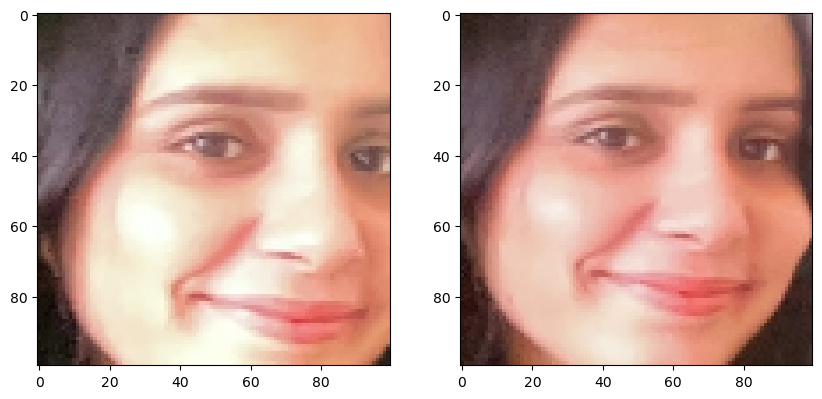

In [80]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[3])

plt.subplot(1,2,2)
plt.imshow(test_val[3])

plt.show()

### Saving the Model

In [81]:
siamese_model.save('siamesemodelv2.keras')

In [82]:
L1Dist

__main__.L1Dist

In [83]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [84]:
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


array([[1.0000000e+00],
       [5.0099623e-01],
       [1.2079907e-04],
       [9.9876899e-01],
       [9.9928796e-01],
       [9.9999148e-01],
       [9.9996877e-01],
       [9.9999970e-01],
       [9.9982655e-01],
       [1.8109498e-05]], dtype=float32)

In [85]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

### Using it Real Time

In [86]:
os.listdir(os.path.join('application_data', 'verification_images'))

['a2c60362-1058-11ef-b2da-42e2edd4dbe4.jpg',
 '52a8c18a-105d-11ef-b2da-42e2edd4dbe4.jpg',
 'a6728c60-1058-11ef-b2da-42e2edd4dbe4.jpg',
 '9e34f358-1058-11ef-b2da-42e2edd4dbe4.jpg',
 '7455f528-105d-11ef-b2da-42e2edd4dbe4.jpg',
 '803b6efe-105d-11ef-b2da-42e2edd4dbe4.jpg',
 '9ee6de9c-1058-11ef-b2da-42e2edd4dbe4.jpg',
 '4b3f75aa-1059-11ef-b2da-42e2edd4dbe4.jpg',
 '7d8896f4-1059-11ef-b2da-42e2edd4dbe4.jpg',
 '763fc5f8-105d-11ef-b2da-42e2edd4dbe4.jpg',
 '47c5c4b0-1059-11ef-b2da-42e2edd4dbe4.jpg',
 'a6a56d60-1058-11ef-b2da-42e2edd4dbe4.jpg',
 '5907209e-105d-11ef-b2da-42e2edd4dbe4.jpg',
 '741e36e2-105d-11ef-b2da-42e2edd4dbe4.jpg']

In [87]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [92]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/a2c60362-1058-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/52a8c18a-105d-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/a6728c60-1058-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/9e34f358-1058-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/7455f528-105d-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/803b6efe-105d-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/9ee6de9c-1058-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/4b3f75aa-1059-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/7d8896f4-1059-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/763fc5f8-105d-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/47c5c4b0-1059-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/a6a56d60-1058-11ef-b2da-42e2edd4dbe4.jpg
application_data/verification_images/5907209e-105d-11ef-b2da-42e

In [93]:
def verify(siamese_model, detection_threshold, verification_threshold):
    
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = siamese_model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [94]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)

        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━

In [95]:
np.sum(np.squeeze(results) > 0.9)

6

In [96]:
results

[array([[0.0012577]], dtype=float32),
 array([[0.9940625]], dtype=float32),
 array([[0.03421941]], dtype=float32),
 array([[0.10377364]], dtype=float32),
 array([[0.9998791]], dtype=float32),
 array([[0.99815863]], dtype=float32),
 array([[0.01264031]], dtype=float32),
 array([[0.00788132]], dtype=float32),
 array([[0.99975926]], dtype=float32),
 array([[0.9997157]], dtype=float32),
 array([[0.00223656]], dtype=float32),
 array([[0.0051749]], dtype=float32),
 array([[0.5921969]], dtype=float32),
 array([[0.9999463]], dtype=float32)]